## ReLU sparseness and dispersion

Loosely done after the "Rectifier Nonlinearities Improve Neural Network Acoustic Models" paper https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf, which introduces leaky relu. Here we use MNIST. 

In [112]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [57]:
tr=datasets.MNIST('data',download=True)
te=datasets.MNIST('data',download=True,train=False)

In [145]:
dev=torch.device('cpu')
if torch.cuda.is_available(): dev=torch.device('cuda')

In [147]:
def getxy(ds):
    ims,ys=zip(*ds)
    xs=torch.stack(list(map(T.ToTensor(),ims)))
    return xs.view((len(xs),-1)).to(dev),torch.tensor(ys).to(dev)

In [148]:
tr_x,tr_y=getxy(tr)
te_x,te_y=getxy(te)
mean,std=tr_x.mean(),tr_x.std()
mean,std

(tensor(0.1307, device='cuda:0'), tensor(0.3081, device='cuda:0'))

In [149]:
def norm(x,mean,std): return (x-mean)/std

In [150]:
tr_x=norm(tr_x,mean,std)
te_x=norm(te_x,mean,std)
tr_x.mean(),tr_x.std(),te_x.mean(),te_x.std()

(tensor(1.4003e-08, device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(0.0060, device='cuda:0'),
 tensor(1.0077, device='cuda:0'))

In [252]:
def getlinmodel(nhid,act=nn.ReLU):
    m=nn.Sequential(
        nn.Linear(784,nhid),act()
        ,nn.Linear(nhid,nhid),act()
        ,nn.Linear(nhid,10)
    )
    with torch.no_grad():
        for l in m:
            if isinstance(l,nn.Linear):
                for p in l.parameters():
                    if p.ndim==1: p.zero_() # zero bias
                    # xavier weights like in paper
                    else: nn.init.xavier_uniform_(p)
    return m.to(dev)

In [253]:
nhid=500
bs=500
epochs=5
lr=.01

def train(act=nn.ReLU):
    tr_dl=data.DataLoader(data.TensorDataset(tr_x,tr_y),batch_size=bs,shuffle=True)
    te_dl=data.DataLoader(data.TensorDataset(te_x,te_y),batch_size=bs)
    m=getlinmodel(nhid,act=act)
    opt=optim.Adam(m.parameters(),lr=lr)
    for ep in range(epochs):
        for xb,yb in tr_dl:
            opt.zero_grad()
            F.cross_entropy(m(xb),yb).backward()
            opt.step()

        with torch.no_grad():
            acc=0.
            for xb,yb in te_dl:
                acc+=(torch.argmax(m(xb),1)==yb).sum().item()
            acc/=len(te_x)
            print(ep+1,acc)
    return m

training Sigmoid
1 0.9531
2 0.9585
3 0.9664
4 0.9656
5 0.9679
activation prob: mean 0.8155727386474609 std 0.14060817658901215 

training Tanh
1 0.9463
2 0.9543
3 0.9509
4 0.9615
5 0.9624
activation prob: mean 0.1049720048904419 std 0.1096164882183075 

training ReLU
1 0.9529
2 0.9619
3 0.9642
4 0.9686
5 0.9695
activation prob: mean 0.11574779450893402 std 0.1238703727722168 

training LeakyReLU
1 0.9589
2 0.9601
3 0.9629
4 0.9668
5 0.966
activation prob: mean 0.10802941024303436 std 0.11503184586763382 



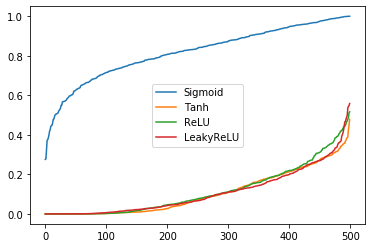

In [263]:
def relu_active(x): return x>0
def tanh_active(x): return (-.95<x)&(x<.95)
def sigm_active(x): return (.05<x)&(x<.95)

for act,active in zip((nn.Sigmoid,nn.Tanh,nn.ReLU,nn.LeakyReLU),
                      (sigm_active,tanh_active,relu_active,relu_active)):
    name=act.__name__
    print('training',name)
    m=train(act)
    a=nn.Sequential(*list(m)[:-1])(te_x).cpu() # take vals from last hidden layer
    a=active(a).float() # get activeness: 1 - active unit, 0 - saturated
    probs=a.mean(dim=0) # get activation probs for each unit
    print('activation prob: mean',probs.mean().item(),'std',probs.std().item(),'\n')
    plt.plot(probs.sort()[0],label=name)
    plt.legend()

* Like in paper, both ReLUs performed better than tanh and similar to each other.
* But unlike paper plotted tanh probs are pretty the same as relu.
* Surprisingly(?) oftentimes sigmoid did a bit better than everyone else.
* As in paper, ReLUs have low activation probs, i.e. sparse.
* But unlike paper they are not very disperse, i.e. stddev is higher.
* The shape of relu and tanh curves differs from paper.
* Tried different init schemes, it didn't change much.
* In paper there were 4 hidden layers 2048 units each. Replicating this here resulted in lots of saturated neurons, i.e. all curves almost 0 almost everywhere.